# <div align = "center"> Расчёт спектров ЯМР по данным регистрации времени релаксации

In [ ]:
from google.colab import drive
drive.mount('/MD')

## Блок импорта необходимых библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!pip install scikit-learn==0.24.1

In [ ]:
!pip install scikit-learn==0.23.2

In [ ]:
  from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV

In [ ]:
 from skopt.space import Real, Categorical, Integer

## Загрузим данные

In [ ]:
init_124 = pd.read_table('/MD/MyDrive/И124.prn', sep = '\s+', header = None, names = ['t, micros', 'A'])
init_4529 = pd.read_table('/MD/MyDrive/И4529.prn', sep = '\s+', header = None, names = ['t, micros', 'A'])
init_122 = pd.read_table('/MD/MyDrive/РБ122.prn', sep = '\s+', header = None, names = ['t, micros', 'A'])

## Построим графики

Text(0, 0.5, 'Amplitude')

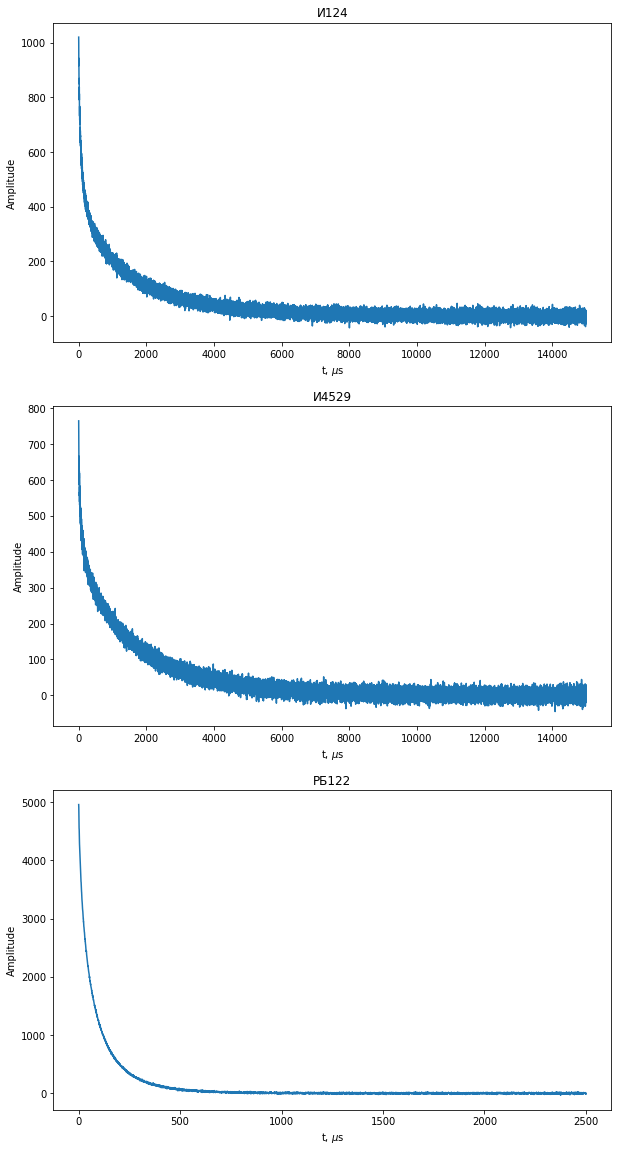

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = [10, 20])
ax1.plot(init_124['t, micros'], init_124['A'])
ax1.set_title('И124')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')

ax2.plot(init_4529['t, micros'], init_4529['A'])
ax2.set_title('И4529')
ax2.set_xlabel('t, $\mu$s')
ax2.set_ylabel('Amplitude')

ax3.plot(init_122['t, micros'], init_122['A'])
ax3.set_title('РБ122')
ax3.set_xlabel('t, $\mu$s')
ax3.set_ylabel('Amplitude')

## Будем приближать спектры суперпозицией экспонент. T2 в количестве 50 штук от 0.1 до 1000 в лог масштабе

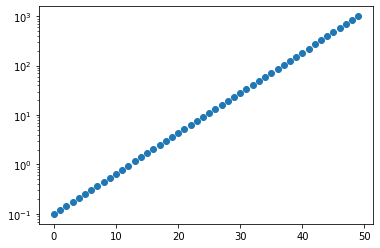

In [ ]:
T2_vals = np.power(10, np.linspace(np.log10(0.1), np.log10(1000), 50))
plt.semilogy(T2_vals, 'o')

In [ ]:
Basis_124 = []
for T2 in T2_vals:
  Basis_124.append(np.exp(- (init_124['t, micros'].values / 1000) / T2))
Basis_124 = np.array(Basis_124)
Basis_124 = Basis_124.T

In [ ]:
Target_124 = init_124['A'].values
Target_124

array([1020.15646585, 1013.58626792, 1001.46467718, ...,   17.01307108,
        -29.29679377,  -16.92217974])

## Регрессия

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Спектр ЯМР (OLS)')

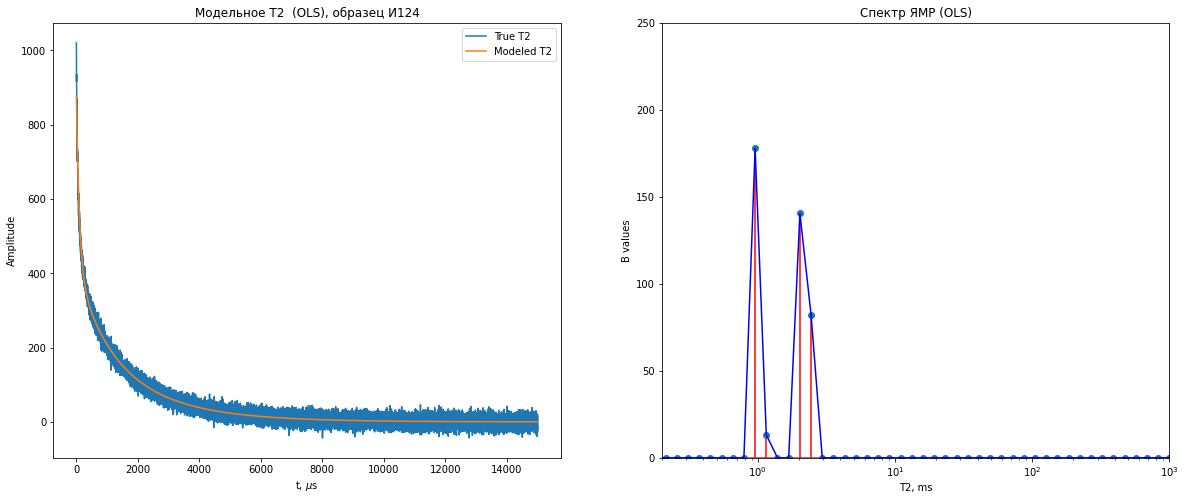

In [ ]:
model1 = LinearRegression(positive = True, fit_intercept = False)
model1.fit(Basis_124, Target_124)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_124['t, micros'], init_124['A'], label = 'True T2')
ax1.plot(init_124['t, micros'], model1.predict(Basis_124), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (OLS), образец И124')
ax1.legend()

ax2.stem(T2_vals, model1.coef_, 'r')
ax2.plot(T2_vals, model1.coef_, 'b')
ax2.set_xscale('log')
ax2.set_xlim(0.2, 1000)
ax2.set_ylim(0, 250)
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (OLS)')

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best alpha: 0.001
val. score: 0.43698972544517106
train score: 0.9850225678105176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Спектр ЯМР (Ridge)')

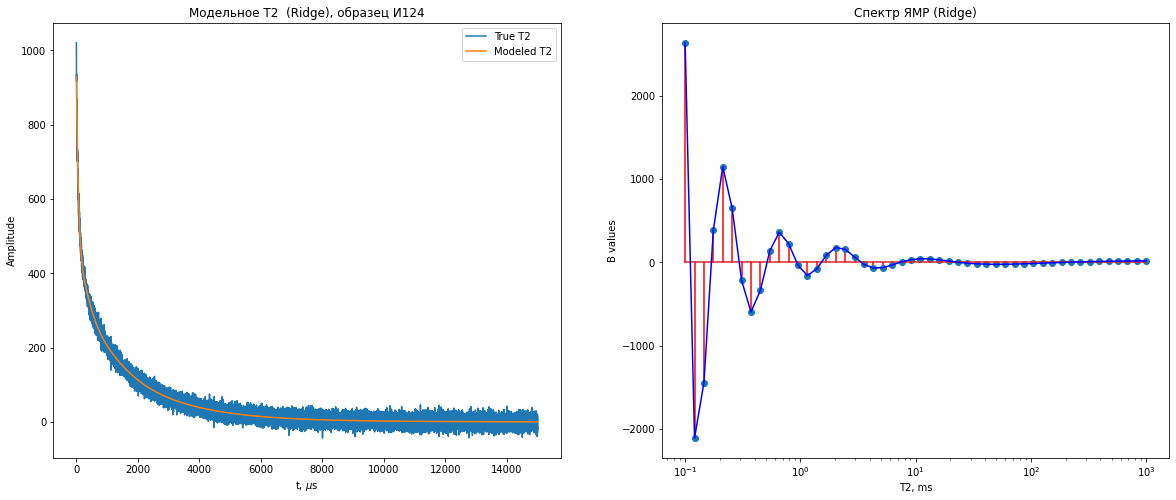

In [ ]:
estimator = Ridge(fit_intercept=False)

model2 = BayesSearchCV(
    estimator,
    {
        'alpha': Real(1e-3, 1e+2, 'uniform')
    },
    optimizer_kwargs = None,
    n_iter=20,
    scoring = 'r2',
    cv = 2
    )

model2.fit(Basis_124, Target_124)

print("best alpha: %s" % model2.best_params_['alpha'])
print("val. score: %s" % model2.best_score_)
print("train score: %s" % model2.score(Basis_124, Target_124))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_124['t, micros'], init_124['A'], label = 'True T2')
ax1.plot(init_124['t, micros'], model2.predict(Basis_124), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (Ridge), образец И124')
ax1.legend()

ax2.stem(T2_vals, model2.best_estimator_.coef_, 'r')
ax2.plot(T2_vals, model2.best_estimator_.coef_, 'b')
ax2.set_xscale('log')
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (Ridge)')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349548.4724954453, tolerance: 35143.1254470134
  positive)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349548.4724954453, tolerance: 35143.1254470134
  positive)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: Conv

best alpha: 0.001
val. score: 0.15427462233786404
train score: 0.9841972836696944


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324574.69052049704, tolerance: 35365.34150409217
  positive)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Спектр ЯМР (Lasso)')

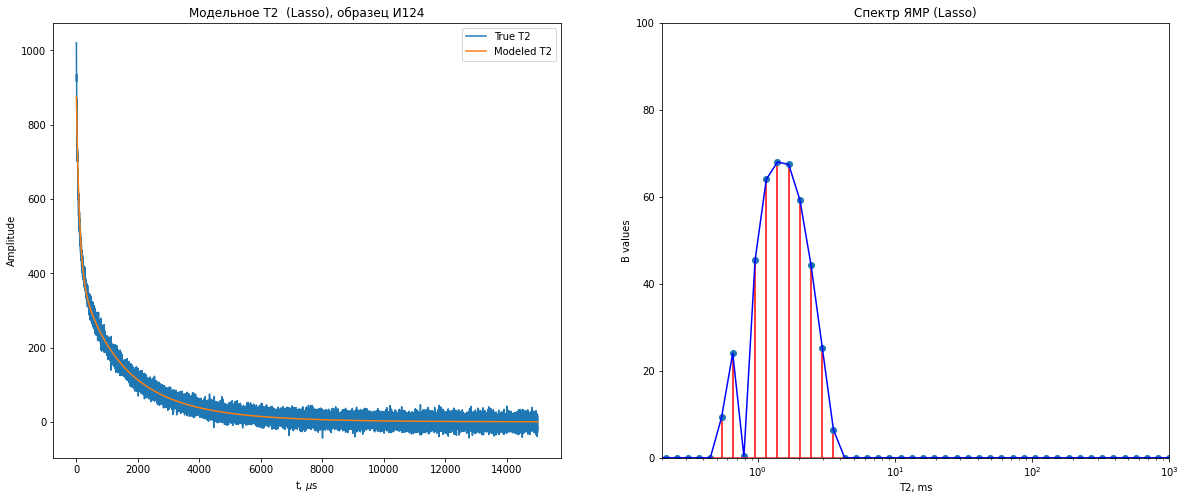

In [ ]:
estimator = Lasso(fit_intercept=False, positive = True)

model3 = BayesSearchCV(
    estimator,
    {
        'alpha': Real(1e-3, 1e+2, 'uniform')
    },
    optimizer_kwargs = None,
    n_iter=40,
    scoring = 'r2',
    cv = 2
    )

model3.fit(Basis_124, Target_124)

print("best alpha: %s" % model3.best_params_['alpha'])
print("val. score: %s" % model3.best_score_)
print("train score: %s" % model3.score(Basis_124, Target_124))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_124['t, micros'], init_124['A'], label = 'True T2')
ax1.plot(init_124['t, micros'], model3.predict(Basis_124), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (Lasso), образец И124')
ax1.legend()

ax2.stem(T2_vals, model3.best_estimator_.coef_, 'r')
ax2.plot(T2_vals, model3.best_estimator_.coef_, 'b')
ax2.set_xscale('log')
ax2.set_xlim(0.2, 1000)
ax2.set_ylim(0, 100)
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (Lasso)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Спектр ЯМР (Lasso)')

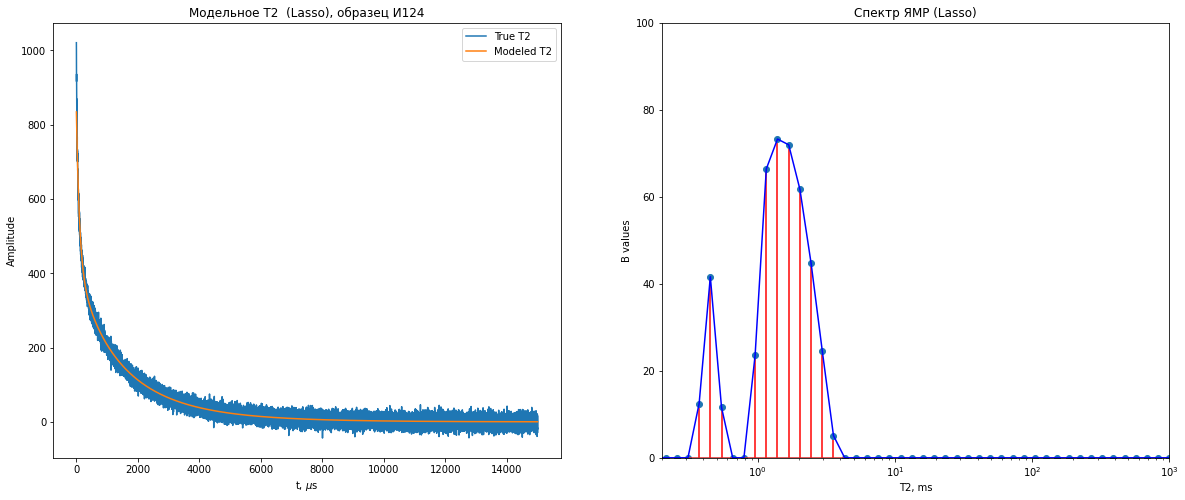

In [ ]:
#estimator = ElasticNet(fit_intercept=False, positive = True)
model4 = ElasticNet(alpha = 0.1, l1_ratio = 1, fit_intercept=False, positive = True)

#model4 = BayesSearchCV(
#    estimator,
#    {
#        'alpha': Real(1e-3, 1e+1, 'uniform'),
#        'l1_ratio': Real(1e-3, 1e+1, 'uniform')
#    },
#    optimizer_kwargs = None,
#    n_iter=75,
#    scoring = 'r2',
#    cv = 2
#    )

model4.fit(Basis_124, Target_124)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_124['t, micros'], init_124['A'], label = 'True T2')
ax1.plot(init_124['t, micros'], model4.predict(Basis_124), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (Lasso), образец И124')
ax1.legend()

#ax2.stem(T2_vals, model4.best_estimator_.coef_, 'r')
#ax2.plot(T2_vals, model4.best_estimator_.coef_, 'b')

ax2.stem(T2_vals, model4.coef_, 'r')
ax2.plot(T2_vals, model4.coef_, 'b')

ax2.set_xscale('log')
ax2.set_xlim(0.2, 1000)
ax2.set_ylim(0, 100)
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (Lasso)')

## Оставим в качестве естиматора модель ElasticNet

In [ ]:
Basis_4529 = []
for T2 in T2_vals:
  Basis_4529.append(np.exp(- (init_4529['t, micros'].values / 1000) / T2))
Basis_4529 = np.array(Basis_4529)
Basis_4529 = Basis_4529.T

In [ ]:
Target_4529 = init_4529['A'].values
Target_4529

array([764.48699781, 756.07478293, 732.9807311 , ...,   8.01694945,
       -15.13391761,   5.01966886])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Спектр ЯМР (Lasso)')

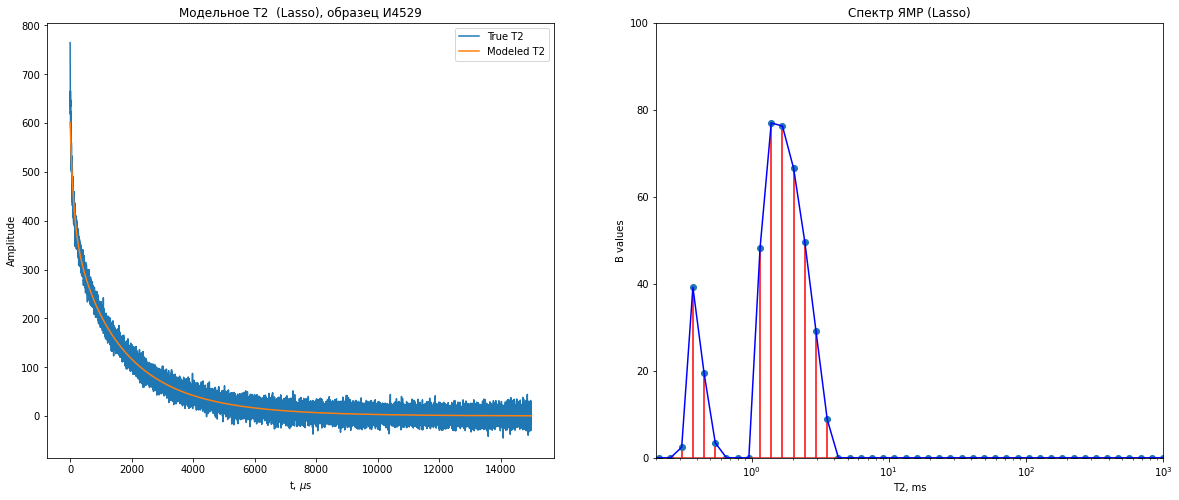

In [ ]:
#estimator = ElasticNet(fit_intercept=False, positive = True)
model4 = ElasticNet(alpha = 0.1, l1_ratio = 1, fit_intercept=False, positive = True)

#model4 = BayesSearchCV(
#    estimator,
#    {
#        'alpha': Real(1e-3, 1e+1, 'uniform'),
#        'l1_ratio': Real(1e-3, 1e+1, 'uniform')
#    },
#    optimizer_kwargs = None,
#    n_iter=75,
#    scoring = 'r2',
#    cv = 2
#    )

model4.fit(Basis_4529, Target_4529)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_4529['t, micros'], init_4529['A'], label = 'True T2')
ax1.plot(init_4529['t, micros'], model4.predict(Basis_4529), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (Lasso), образец И4529')
ax1.legend()

#ax2.stem(T2_vals, model4.best_estimator_.coef_, 'r')
#ax2.plot(T2_vals, model4.best_estimator_.coef_, 'b')

ax2.stem(T2_vals, model4.coef_, 'r')
ax2.plot(T2_vals, model4.coef_, 'b')

ax2.set_xscale('log')
ax2.set_xlim(0.2, 1000)
ax2.set_ylim(0, 100)
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (Lasso)')

In [ ]:
Basis_122 = []
for T2 in T2_vals:
  Basis_122.append(np.exp(- (init_122['t, micros'].values / 1000) / T2))
Basis_122 = np.array(Basis_122)
Basis_122 = Basis_122.T

In [ ]:
Target_122 = init_122['A'].values
Target_122

array([ 4.96099722e+03,  4.91787625e+03,  4.73395728e+03, ...,
        5.48543587e-01,  4.93456285e+00, -1.41816952e+01])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Спектр ЯМР (Lasso)')

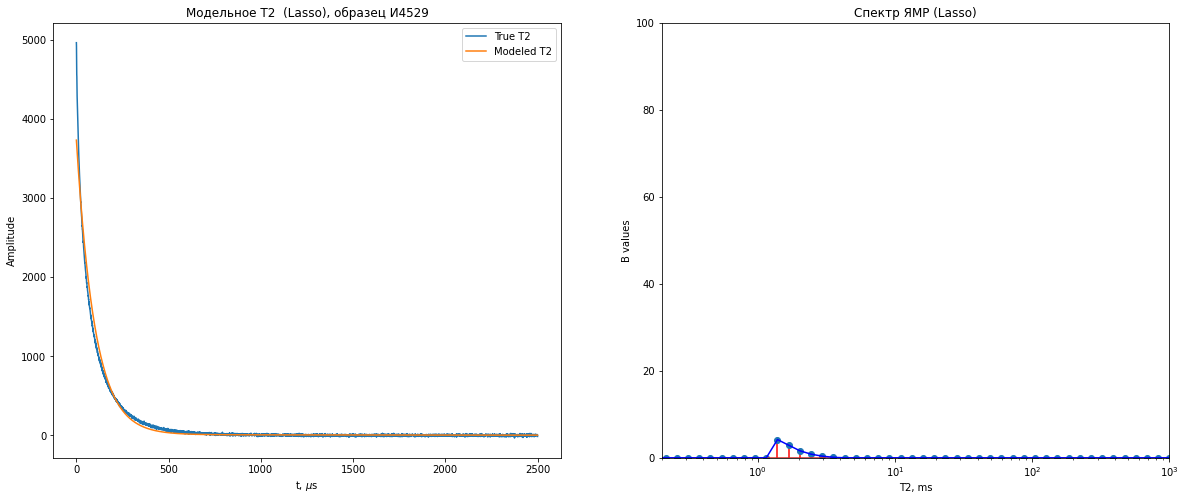

In [ ]:
#estimator = ElasticNet(fit_intercept=False, positive = True)
model4 = ElasticNet(alpha = 0.1, l1_ratio = 1, fit_intercept=False, positive = True)

#model4 = BayesSearchCV(
#    estimator,
#    {
#        'alpha': Real(1e-3, 1e+1, 'uniform'),
#        'l1_ratio': Real(1e-3, 1e+1, 'uniform')
#    },
#    optimizer_kwargs = None,
#    n_iter=75,
#    scoring = 'r2',
#    cv = 2
#    )

model4.fit(Basis_122, Target_122)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 8])
ax1.plot(init_122['t, micros'], init_122['A'], label = 'True T2')
ax1.plot(init_122['t, micros'], model4.predict(Basis_122), label = 'Modeled T2')
ax1.set_xlabel('t, $\mu$s')
ax1.set_ylabel('Amplitude')
ax1.set_title('Модельное T2  (Lasso), образец И4529')
ax1.legend()

#ax2.stem(T2_vals, model4.best_estimator_.coef_, 'r')
#ax2.plot(T2_vals, model4.best_estimator_.coef_, 'b')

ax2.stem(T2_vals, model4.coef_, 'r')
ax2.plot(T2_vals, model4.coef_, 'b')

ax2.set_xscale('log')
ax2.set_xlim(0.2, 1000)
ax2.set_ylim(0, 100)
ax2.set_xlabel('T2, ms')
ax2.set_ylabel('B values')
ax2.set_title('Спектр ЯМР (Lasso)')